In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as npç
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 
from lightgbm import  LGBMRegressor
import pickle
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
sales_train_evaluation_ = pd.read_csv('/content/sales_train_evaluation.csv')
calendar_ = pd.read_csv('/content/calendar.csv')
sell_prices_ = pd.read_csv('/content/sell_prices.csv')
STORES_IDS = list(sales_train_evaluation_['store_id'].unique())

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def data_processing(x):
  #Adding columns for the days d_1942 to d_1969 as nan for which we need to forecast sales
  for i in range(1942,1970):
      x['d_'+str(i)]=np.nan
      x['d_'+str(i)]=x['d_'+str(i)].astype(np.float16)

  # Melting to convert one date to one observation
  df=pd.melt(x,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='demand')
  # Merge calendar and sell_prices data
  df=pd.merge(df,calendar_,on='d',how='left')
  df=pd.merge(df,sell_prices_,on=['item_id','store_id','wm_yr_wk'],how='left')
  df['sell_price']=df.groupby(['id'])['sell_price'].apply(lambda x: x.fillna(x.mean()))

  # Fill events N/A
  cat=['event_name_1','event_type_1','event_name_2','event_type_2']
  for i in cat:
      df[i].fillna('no_event',inplace=True)

  # Create is_weekend feature
  f=lambda x: 1 if x<=2 else 0
  df['is_weekend']=df['wday'].map(f)
  df['is_weekend']=df['is_weekend'].astype(np.int8)

  # Create month_day feature
  f=lambda x: x.split("-")[2]
  df['month_day']=df['date'].map(f)
  df['month_day']=df['month_day'].astype(np.int8)

  # Create month_week_number feature
  df['month_week_number']=(df['month_day']-1) // 7 + 1  
  df['month_week_number']=df['month_week_number'].astype(np.int8)

  # Get sales by 3 aggregation level: store_id, item_id, store_id+dept_id
  store_demand = df.groupby(['store_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'store_demand'})
  df = pd.merge(df, store_demand, on=['store_id','d'],how='left')
  del store_demand

  item_demand = df.groupby(['item_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'item_demand'})
  df = pd.merge(df, item_demand, on=['item_id','d'],how='left')
  del item_demand

  store_dept_demand = df.groupby(['store_id','dept_id','d'])['demand'].sum().reset_index().rename(columns={'demand':'store_dept_demand'})
  df = pd.merge(df, store_dept_demand, on=['store_id','dept_id','d'],how='left')
  del store_dept_demand

  # Create lag variables
  lag_col_prefixs = ['lag_','lag_price_','lag_store_demand_','lag_item_demand_','lag_store_dept_demand_']
  lag_col_names = ['demand','sell_price','store_demand','item_demand','store_dept_demand']
  for col_prefix, col_name in zip(lag_col_prefixs, lag_col_names):
    lags=[28,35,42]
    lag_cols=[]
    for i in lags:
        df[col_prefix+str(i)]=df.groupby(['id'])[col_name].shift(i)
        lag_cols.append(col_prefix+str(i))
    # lag_cols=['lag_28','lag_35','lag_42']
    for i in lag_cols:
        df[i].fillna(0,inplace=True)

  # demand mean&std
  for val in [7, 30, 60, 90, 180]:
          df[f"rolling_std_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).std())
  for val in [7, 30, 60, 90, 180]:
        df[f"rolling_mean_t{val}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).mean())

  df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform( lambda x: x.shift(28).rolling(30).skew())
  df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(30).kurt())
    
  # price features
  df['lag_price_t1'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
  df['price_change_t1'] = (df['lag_price_t1'] - df['sell_price']) / (df['lag_price_t1'])
  df['rolling_price_max_t365'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
  df['price_change_t365'] = (df['rolling_price_max_t365'] - df['sell_price']) / (df['rolling_price_max_t365'])
  df['rolling_price_std_t7'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
  df['rolling_price_std_t30'] = df.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
  df.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)

  # Encoding
  labelencoder=LabelEncoder() 
  category=['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
  for i in category:
      df[i+'_']=labelencoder.fit_transform(df[i])

  df=df.drop(['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id'],axis=1)

  # Convert string date to int date
  f=lambda x: x.split('_')[1]
  df['day']=df['d'].map(f)
  df['day']=df['day'].astype(np.int16) 

  # Cleanup - drop redundant columns
  df=df.drop(['d','date','weekday'],axis=1)

  return df

In [ ]:
############ Data Processing ############
# Calculate event count each day
calendar_['event_count'] = calendar_[['event_name_1','event_name_2']].apply(lambda x: 2-x.isna().sum(), axis=1)
# Apply data_processing function
sales_train_evaluation_ = reduce_mem_usage(sales_train_evaluation_)
processed_df = data_processing(sales_train_evaluation_)

Mem. usage decreased to 96.13 Mb (78.8% reduction)


In [ ]:
############ Hyperparameter tuning with RandomizedSearchCV ############
def custom_split(X, y, groups):
  for train_index, test_index in groups:
    original_train_index = np.array(X[X['day'].isin(train_index+1)].index)
    original_test_index = np.array(X[X['day'].isin(test_index+1)].index)
    yield original_train_index, original_test_index

# Train by store
STORES_IDS = list(processed_df['store_id_'].unique())
for store_id in STORES_IDS:
  df1 = processed_df[processed_df.store_id_ == store_id]
  # file_path = 'processed_data_by_store/'+store_id+'.csv'
  # df1 = pd.read_csv(file_path)
  df1 = reduce_mem_usage(df1)
  # remove testing data
  df1 = df1[df1['day']<1942]

  df1 = df1.reset_index().drop("index",axis=1)
  X = df1.iloc[:, 1:]
  y = df1['demand']
  
  tscv = TimeSeriesSplit(n_splits=5, test_size=28)
  groups = tscv.split(df1['day'].unique())

  lgb = LGBMRegressor(objective="tweedie")

  lgb_grid = {'learning_rate': reciprocal(3e-3, 3e-1),
            'max_depth': list(range(50,70)) ,
            'num_leaves': list(range(150,300)) ,
            'n_estimators': list(range(100,200))}

  lgb_reg = RandomizedSearchCV(lgb, param_distributions=lgb_grid,
                            n_jobs=-1, scoring = 'neg_mean_squared_error', cv=custom_split(X, y, groups))
  lgb_reg.fit(X, y)
  print(store_id, '\t', lgb_reg.best_params_)
  print(store_id, '\t', lgb_reg.best_score_)
  model_path = 'lgb_model_dump/lgb_model_store_'+str(store_id)+'.bin'
  pickle.dump(lgb_reg.best_estimator_, open(model_path, 'wb'))

Mem. usage decreased to 389.32 Mb (79.8% reduction)


In [ ]:
# Initialize submission dataframe
pred_test=pd.DataFrame()
pred_test['id']=sales_train_evaluation_['id']
pred_test['store_id']=sales_train_evaluation_['store_id'] 
for i in range(1,29):
    pred_test['F'+str(i)]=np.nan
    pred_test['F'+str(i)]=pred_test['F'+str(i)].astype(np.float16)

In [ ]:
# Make test predictions by store
for store_id in STORES_IDS:
  file_path = '/content/'+store_id+'.csv'
  df = pd.read_csv(file_path)
  x_test=df.loc[df['day']>=1942]
  x_test = x_test.drop(['demand'],axis=1)
  model_path = '/content/lgb_model_'+store_id+'.bin'
  lgb = pickle.load(open(model_path, 'rb'))
  k=1
  for i in range(1942,1970):
    # Read all our models and make predictions for each day/store pairs
    pred_test['F'+str(k)][pred_test['store_id']==store_id]=lgb.predict(x_test[x_test['day']==(i)]) 
    k+=1
    
prediction_test=pred_test

In [ ]:
# Output the final submission file
import time 
current_timestamp = int(time.time())
prediction_test = prediction_test.drop('store_id',axis=1)
sample_submission = pd.read_csv('/content/sample_submission.csv')
sample_validation = sample_submission.iloc[:30490,:]
final = pd.concat([sample_validation, prediction_test])
file_path = '/content/prediction_result' + str(current_timestamp) + '.csv'
final.to_csv(file_path,index=False)

Mem. usage decreased to 206.11 Mb (82.7% reduction)


<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

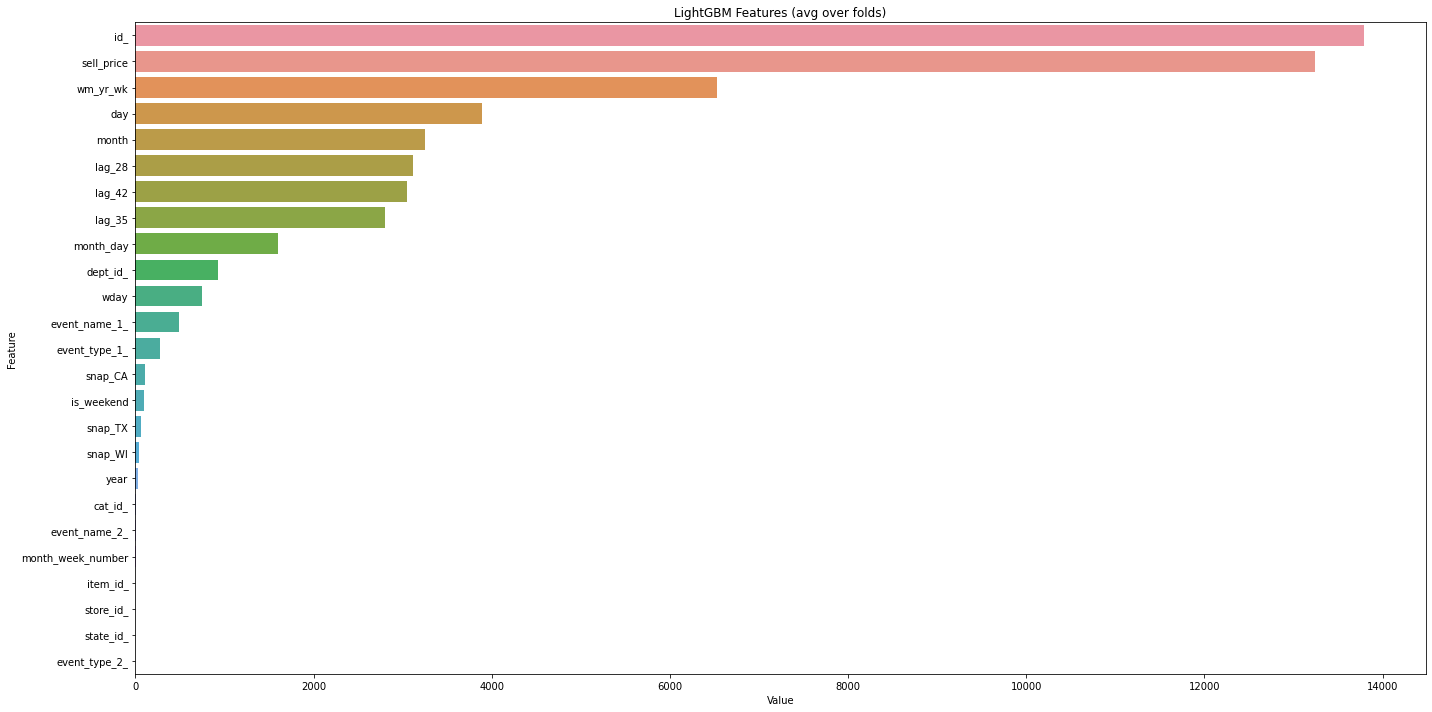

In [ ]:
############ Feature Importance ############
model_path = '/content/lgb_model_'+"CA_1"+'.bin'
lgb_ca_1 = pickle.load(open(model_path, 'rb'))
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
file_path = '/content/'+'CA_1'+'.csv'
df1 = pd.read_csv(file_path)
df1 = reduce_mem_usage(df1)
 # remove testing data
df1 = df1[df1['day']<1942]

df = df1.reset_index().drop("index",axis=1)
X = df.iloc[:, 1:]
y = df['demand']
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_ca_1.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

Mem. usage decreased to 206.11 Mb (82.7% reduction)


<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

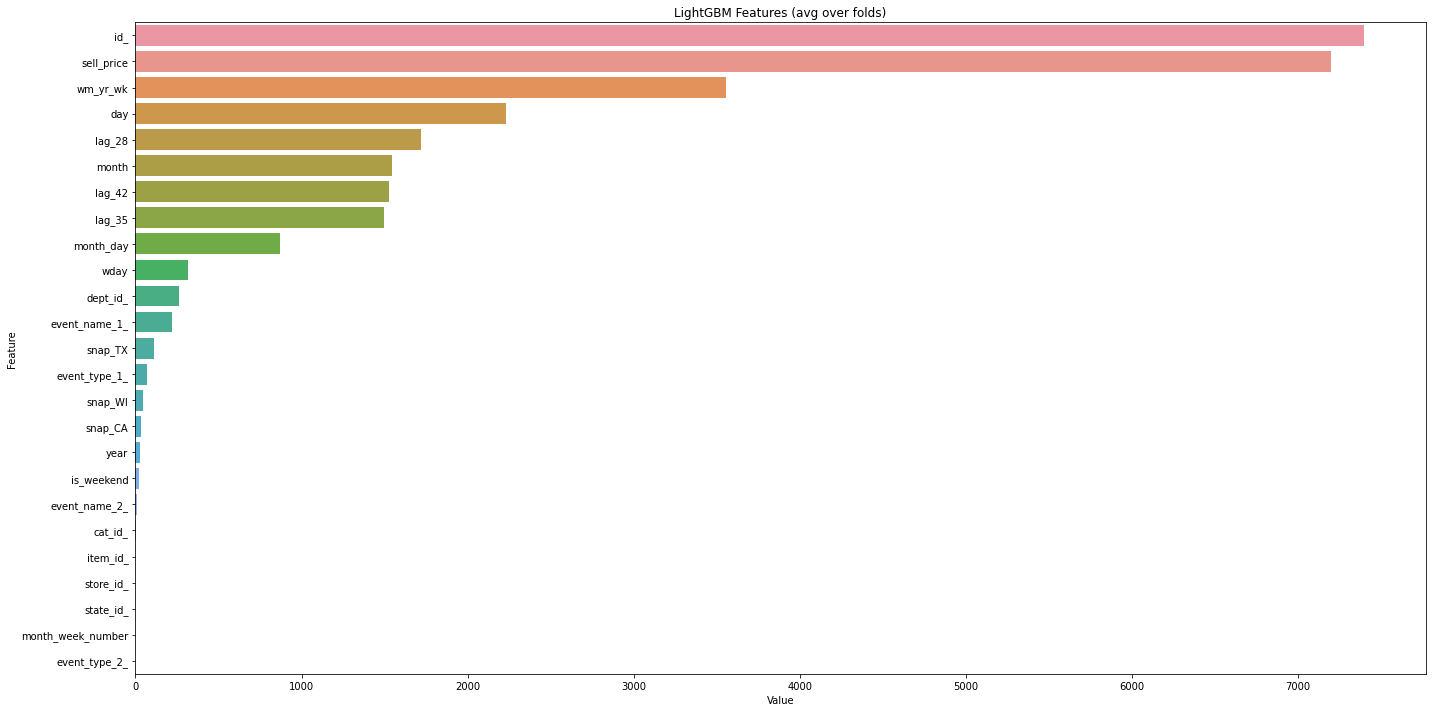

In [ ]:
model_path = '/content/lgb_model_'+"TX_1"+'.bin'
TX_1 = pickle.load(open(model_path, 'rb'))
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
file_path = '/content/'+'TX_1'+'.csv'
df1 = pd.read_csv(file_path)
df1 = reduce_mem_usage(df1)
 # remove testing data
df1 = df1[df1['day']<1942]

df = df1.reset_index().drop("index",axis=1)
X = df.iloc[:, 1:]
y = df['demand']
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(TX_1.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()